In [1]:
import os
import numpy as np, pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def save_plot_and_show(name, dir_path="plots"):
    """Сохраняет активную фигуру"""
    os.makedirs(dir_path, exist_ok=True)
    filepath = os.path.join(dir_path, f"{name}.png")
    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
plt.rcParams.update({
    'font.size': 14,           # Размер основного шрифта
    'axes.titlesize': 16,      # Размер заголовков осей
    'axes.labelsize': 16,      # Размер подписей осей
    'xtick.labelsize': 14,     # Размер подписей по оси X
    'ytick.labelsize': 14,     # Размер подписей по оси Y
    'legend.fontsize': 12,     # Размер шрифта легенды
})

In [2]:
train = pd.read_csv(f"data/train.csv")
test  = pd.read_csv(f"data/test.csv")
target = "delay_minutes"

In [3]:
def add_time_feats(df):
    x = 2*np.pi*(df["planned_arrival_min"]/1440.0)
    df = df.copy()
    df["time_sin"], df["time_cos"] = np.sin(x), np.cos(x)
    df["hour"] = (df["planned_arrival_min"]//60 % 24).astype(int)
    return df

train = add_time_feats(train)
test  = add_time_feats(test)
print(train.shape)

(86671, 17)


In [4]:
train.head(n=2)

,id,route_id,trip_id,stop_sequence,planned_arrival_min,weekday,is_holiday,distance_run_km,headway_min,temp_c,precip_mm,wind_mps,traffic_index,delay_minutes,time_sin,time_cos,hour
0,1,R00,R00_20240401_0302,0,302.00,0,0,0.000,19.45,9.51,0.0,0.3,2.9,2.35,0.968148,0.25038,5
1,2,R00,R00_20240401_0302,1,303.88,0,0,0.443,19.45,9.51,0.0,0.3,2.9,0.81,0.970169,0.24243,5


In [6]:
y = train[target].clip(lower=0)
num = ["stop_sequence","planned_arrival_min","distance_run_km","headway_min","temp_c","precip_mm","wind_mps",
            "traffic_index","time_sin","time_cos","hour"]
cat = ["route_id","weekday","is_holiday"]
X = train[num+cat]
X_test = test[num+cat]
groups = train["trip_id"]
X.head(n=5)

,stop_sequence,planned_arrival_min,distance_run_km,headway_min,temp_c,precip_mm,wind_mps,traffic_index,time_sin,time_cos,hour,route_id,weekday,is_holiday
0,0,302.00,0.000,19.45,9.51,0.0,0.3,2.9,0.968148,0.250380,5,R00,0,0
1,1,303.88,0.443,19.45,9.51,0.0,0.3,2.9,0.970169,0.242430,5,R00,0,0
2,2,307.68,1.489,19.45,9.51,0.0,0.3,2.9,0.974055,0.226311,5,R00,0,0
3,3,310.80,2.323,19.45,9.51,0.0,0.3,2.9,0.977046,0.213030,5,R00,0,0
4,4,313.51,3.026,19.45,9.51,0.0,0.3,2.9,0.979496,0.201463,5,R00,0,0


In [7]:
def validate_model(X):
    pre = ColumnTransformer([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat)
    ], remainder="passthrough")
    
    model = Pipeline([
        ("pre", pre),
        ("rf", HistGradientBoostingRegressor(random_state=42))
    ])
    
    cv = GroupKFold(n_splits=5)
    oof = np.zeros(len(X))
    for fold, (tr, va) in enumerate(cv.split(X, y, groups=groups), 1):
        model.fit(X.iloc[tr], y.iloc[tr])
        oof[va] = model.predict(X.iloc[va])
        rmse = root_mean_squared_error(y.iloc[va], oof[va])
        print(f"Fold {fold} RMSE: {rmse:.4f}")
    print("CV RMSE:", root_mean_squared_error(y, oof))

In [8]:
validate_model(X)

Fold 1 RMSE: 1.4543
Fold 2 RMSE: 1.4727
Fold 3 RMSE: 1.4627
Fold 4 RMSE: 1.4557
Fold 5 RMSE: 1.4594
CV RMSE: 1.460981896278909


In [9]:
# 1. is_rush_hour (утренний и вечерний часы пик)
X['is_rush_hour'] = ((X['hour'] >= 7) & (X['hour'] <= 8)) | ((X['hour'] >= 15) & (X['hour'] <= 18))
X['is_rush_hour'] = X['is_rush_hour'].astype(int)

# 2. part_of_day (категориальный признак части дня)
# Создаем функцию для категоризации
def get_part_of_day(hour):
    if 4 <= hour <= 6:
        return 'early_morning'
    elif 7 <= hour <= 8:
        return 'morning_rush'
    elif 9 <= hour <= 14:
        return 'day'
    elif 15 <= hour <= 18:
        return 'evening_rush'
    else:
        return 'night_evening' # 19-23, 0-3

X['part_of_day'] = X['hour'].apply(get_part_of_day)

# 3. weekend (бинарный признак выходных)
X['is_weekend'] = X['weekday'].isin([5, 6]).astype(int) # 5=Сб, 6=Вс
X.head(n=3)

C:\Users\verdex\AppData\Local\Temp\ipykernel_5916\2930321021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_rush_hour'] = ((X['hour'] >= 7) & (X['hour'] <= 8)) | ((X['hour'] >= 15) & (X['hour'] <= 18))
C:\Users\verdex\AppData\Local\Temp\ipykernel_5916\2930321021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_rush_hour'] = X['is_rush_hour'].astype(int)
C:\Users\verdex\AppData\Local\Temp\ipykernel_5916\2930321021.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,stop_sequence,planned_arrival_min,distance_run_km,headway_min,temp_c,precip_mm,wind_mps,traffic_index,time_sin,time_cos,hour,route_id,weekday,is_holiday,is_rush_hour,part_of_day,is_weekend
0,0,302.00,0.000,19.45,9.51,0.0,0.3,2.9,0.968148,0.250380,5,R00,0,0,0,early_morning,0
1,1,303.88,0.443,19.45,9.51,0.0,0.3,2.9,0.970169,0.242430,5,R00,0,0,0,early_morning,0
2,2,307.68,1.489,19.45,9.51,0.0,0.3,2.9,0.974055,0.226311,5,R00,0,0,0,early_morning,0


In [10]:
# num
cat += ["is_rush_hour","part_of_day","is_weekend"]
validate_model(X)

Fold 1 RMSE: 1.4533
Fold 2 RMSE: 1.4722
Fold 3 RMSE: 1.4618
Fold 4 RMSE: 1.4541
Fold 5 RMSE: 1.4601
CV RMSE: 1.4603211443443476


In [11]:
# 1. route_avg_delay (средняя задержка по маршруту)
# Рассчитываем статистику на полном тренировочном наборе
route_stats = train.groupby('route_id')['delay_minutes'].agg('mean').reset_index()
route_stats.columns = ['route_id', 'route_avg_delay']

# Маппим статистику на датафрейм для обучения (X)
X = X.merge(route_stats[['route_id', 'route_avg_delay']], on='route_id', how='left')
X['stop_seq_x_route_delay'] = X['stop_sequence'] * X['route_avg_delay']
X.head(n=3)

,stop_sequence,planned_arrival_min,distance_run_km,headway_min,temp_c,precip_mm,wind_mps,traffic_index,time_sin,time_cos,hour,route_id,weekday,is_holiday,is_rush_hour,part_of_day,is_weekend,route_avg_delay,stop_seq_x_route_delay
0,0,302.00,0.000,19.45,9.51,0.0,0.3,2.9,0.968148,0.250380,5,R00,0,0,0,early_morning,0,1.788858,0.000000
1,1,303.88,0.443,19.45,9.51,0.0,0.3,2.9,0.970169,0.242430,5,R00,0,0,0,early_morning,0,1.788858,1.788858
2,2,307.68,1.489,19.45,9.51,0.0,0.3,2.9,0.974055,0.226311,5,R00,0,0,0,early_morning,0,1.788858,3.577717


In [12]:
num += ["route_avg_delay","stop_seq_x_route_delay"]
# cat += []
validate_model(X)

Fold 1 RMSE: 1.4541
Fold 2 RMSE: 1.4732
Fold 3 RMSE: 1.4630
Fold 4 RMSE: 1.4543
Fold 5 RMSE: 1.4590
CV RMSE: 1.4607409118741463


In [13]:
# 1. headway_inv (обратная величина интервала - "интенсивность движения")
X['headway_inv'] = 1 / X['headway_min']

# 2. headway_vs_route_avg (отклонение интервала от среднего по маршруту)
# Рассчитываем средний headway по маршруту на тренировочных данных
route_avg_headway = train.groupby('route_id')['headway_min'].mean().reset_index()
route_avg_headway.columns = ['route_id', 'route_avg_headway']

# Маппим и создаем признак
X = X.merge(route_avg_headway, on='route_id', how='left')
X['headway_vs_route_avg'] = X['headway_min'] / X['route_avg_headway']
X.head(n=3)

,stop_sequence,planned_arrival_min,distance_run_km,headway_min,temp_c,precip_mm,wind_mps,traffic_index,time_sin,time_cos,...,weekday,is_holiday,is_rush_hour,part_of_day,is_weekend,route_avg_delay,stop_seq_x_route_delay,headway_inv,route_avg_headway,headway_vs_route_avg
0,0,302.00,0.000,19.45,9.51,0.0,0.3,2.9,0.968148,0.250380,...,0,0,0,early_morning,0,1.788858,0.000000,0.051414,16.573224,1.17358
1,1,303.88,0.443,19.45,9.51,0.0,0.3,2.9,0.970169,0.242430,...,0,0,0,early_morning,0,1.788858,1.788858,0.051414,16.573224,1.17358
2,2,307.68,1.489,19.45,9.51,0.0,0.3,2.9,0.974055,0.226311,...,0,0,0,early_morning,0,1.788858,3.577717,0.051414,16.573224,1.17358


In [14]:
num += ["headway_inv","headway_vs_route_avg"]
# cat += []
validate_model(X)

Fold 1 RMSE: 1.4540
Fold 2 RMSE: 1.4734
Fold 3 RMSE: 1.4621
Fold 4 RMSE: 1.4547
Fold 5 RMSE: 1.4594
CV RMSE: 1.4607333585312436


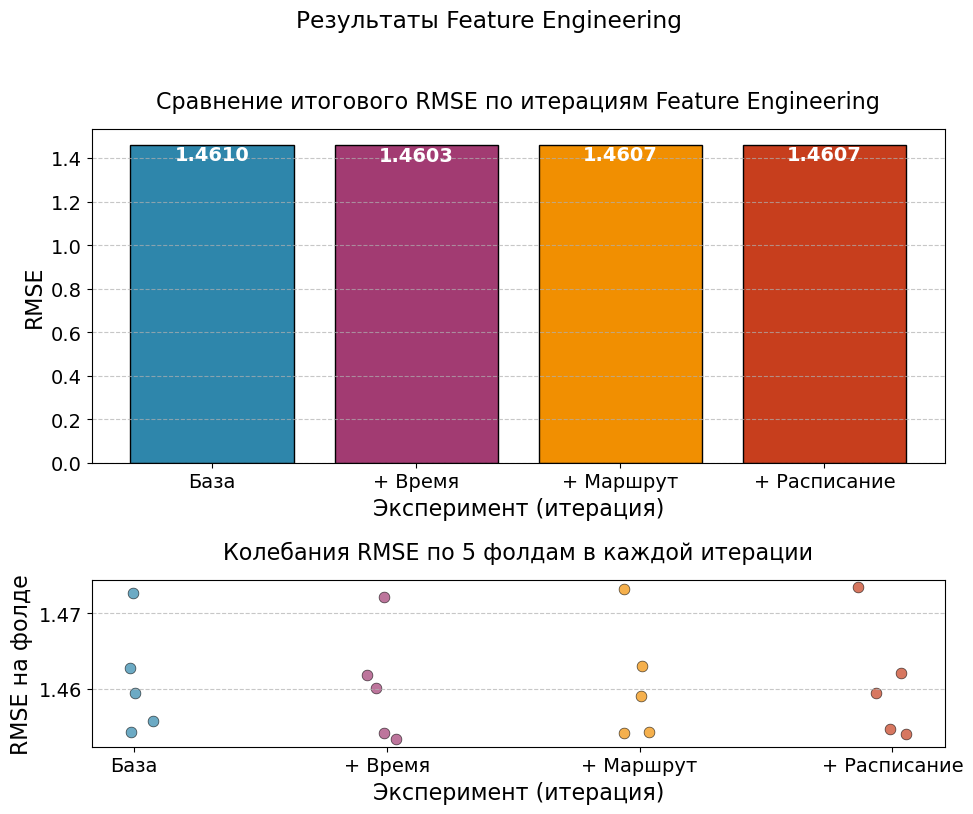

In [20]:
iterations = ['База', '+ Время', '+ Маршрут', '+ Расписание']
avg_rmse = [1.4610, 1.4603, 1.4607, 1.4607]  # Итоговый средний RMSE для каждой итерации

# Примерные данные по 5 фолдам для каждой итерации (ЗАМЕНИТЕ на ваши реальные значения!)
fold_data = {
    'База': [1.4543, 1.4727, 1.4627, 1.4557, 1.4594],  # RMSE по 5 фолдам для Базовой модели
    '+ Время': [1.4533, 1.4722, 1.4618, 1.4541, 1.4601],
    '+ Маршрут': [1.4541, 1.4732, 1.4630, 1.4543, 1.4590],
    '+ Расписание': [1.4540, 1.4734, 1.4621, 1.4547, 1.4594]
}

# 1. Создаём фигуру с двумя subplot: барчарт и точечная диаграмма
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[2, 1])

# 2. БАРЧАРТ: Средний RMSE по итерациям
x_pos = np.arange(len(iterations))
bars = ax1.bar(x_pos, avg_rmse, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'], edgecolor='black')

# Настройки первого графика
ax1.set_title('Сравнение итогового RMSE по итерациям Feature Engineering', pad=15)
ax1.set_xlabel('Эксперимент (итерация)')
ax1.set_ylabel('RMSE')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(iterations, rotation=0)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем значения на столбцы
for bar, value in zip(bars, avg_rmse):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height - 0.003,
            f'{value:.4f}', ha='center', va='top', color='white', fontweight='bold')

# 3. ТОЧЕЧНАЯ ДИАГРАММА: Колебания по фолдам
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
for i, (iter_name, fold_values) in enumerate(fold_data.items()):
    # Разбрасываем точки по горизонтали для наглядности
    x_jittered = np.random.normal(i, 0.05, size=len(fold_values))
    ax2.scatter(x_jittered, fold_values, alpha=0.7, color=colors[i], s=60, label=iter_name, edgecolors='black', linewidth=0.5)

# Настройки второго графика
ax2.set_title('Колебания RMSE по 5 фолдам в каждой итерации', pad=15)
ax2.set_xlabel('Эксперимент (итерация)')
ax2.set_ylabel('RMSE на фолде')
ax2.set_xticks(range(len(iterations)))
ax2.set_xticklabels(iterations, rotation=0)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Общие настройки
plt.suptitle('Результаты Feature Engineering', y=1.02)
plt.tight_layout()

# 5. Сохраняем график
save_plot_and_show('feature_engineering_rmse_comparison')